In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:

'''def leer_acelerograma_igp(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    encabezado = {}
    patrones = {
        "nombre_estacion": r"NOMBRE\s*:\s*(.*)",
        "codigo_estacion": r"CODIGO\s*:\s*(.*)",
        "latitud_est": r"LATITUD\s*:\s*([-\d.]+)",
        "longitud_est": r"LONGITUD\s*:\s*([-\d.]+)",
        "fecha_local": r"FECHA LOCAL\s*:\s*(.*)",
        "hora_local": r"HORA LOCAL\s*:\s*(.*)",
        "latitud_eq": r"LATITUD\s*:\s*([-\d.]+)",
        "longitud_eq": r"LONGITUD\s*:\s*([-\d.]+)",
        "profundidad_km": r"PROFUNDIDAD\s*:\s*([\d.]+)",
        "magnitud": r"MAGNITUD\s*:\s*M([\d.]+)",
        "dist_epicentral_km": r"DIST\. EPICENTRAL\s*:\s*([\d.]+)",
        "muestreo_hz": r"MUESTREO\s*:\s*([\d.]+)",
        "num_muestras": r"NUMERO DE MUESTRAS\s*:\s*(\d+)",
        "inicio_utc": r"TIEMPO DE INICIO\s*:\s*(.*UTC)",
        "pga_z": r"PGA\s*:\s*([\d.]+)",
        "pga_n": r"PGA\s*:\s*[\d.]+\s+([\d.]+)",
        "pga_e": r"PGA\s*:\s*[\d.]+\s+[\d.]+\s+([\d.]+)"
    }

    text = "\n".join(lines)
    for key, pattern in patrones.items():
        m = re.search(pattern, text)
        if m:
            encabezado[key] = m.group(1).strip()

    # Buscar el inicio de la tabla de datos
    start_idx = None
    for i, line in enumerate(lines):
        if re.match(r"^\s*Z\s+N\s+E", line):
            start_idx = i + 1
            break

    if start_idx is None:
        raise ValueError(f"No se encontró bloque de datos en {filepath}")

    # Leer datos numéricos
    data = []
    for line in lines[start_idx:]:
        parts = line.split()
        if len(parts) == 3:
            try:
                data.append([float(p) for p in parts])
            except ValueError:
                pass

    df_data = pd.DataFrame(data, columns=["Z", "N", "E"])
    df_data["tiempo_s"] = df_data.index / float(encabezado.get("muestreo_hz", 100.0))

    # Agregar metadatos a cada fila
    for key, val in encabezado.items():
        df_data[key] = val

    df_data["archivo"] = os.path.basename(filepath)
    return df_data


def leer_todos_los_registros(ruta_base):
    registros = []
    for root, _, files in os.walk(ruta_base):
        for file in files:
            if file.lower().endswith(".txt"):
                filepath = os.path.join(root, file)
                try:
                    df = leer_acelerograma_igp(filepath)
                    registros.append(df)
                    print(f"✅ Leído correctamente: {file}")
                except Exception as e:
                    print(f"⚠️ Error leyendo {file}: {e}")

    if registros:
        df_total = pd.concat(registros, ignore_index=True)
        return df_total
    else:
        print("No se encontraron archivos .txt.")
        return pd.DataFrame()


In [ ]:
import os
import re
import pandas as pd
import time

def leer_acelerograma_igp(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]

    encabezado = {}
    patrones = {
        "nombre_estacion": r"NOMBRE\s*:\s*(.*)",
        "codigo_estacion": r"CODIGO\s*:\s*(.*)",
        "latitud_est": r"LATITUD\s*:\s*([-\d.]+)",
        "longitud_est": r"LONGITUD\s*:\s*([-\d.]+)",
        "fecha_local": r"FECHA LOCAL\s*:\s*(.*)",
        "hora_local": r"HORA LOCAL\s*:\s*(.*)",
        "latitud_eq": r"LATITUD\s*:\s*([-\d.]+)",
        "longitud_eq": r"LONGITUD\s*:\s*([-\d.]+)",
        "profundidad_km": r"PROFUNDIDAD\s*:\s*([\d.]+)",
        "magnitud": r"MAGNITUD\s*:\s*M([\d.]+)",
        "dist_epicentral_km": r"DIST\. EPICENTRAL\s*:\s*([\d.]+)",
        "muestreo_hz": r"MUESTREO\s*:\s*([\d.]+)",
        "num_muestras": r"NUMERO DE MUESTRAS\s*:\s*(\d+)",
        "inicio_utc": r"TIEMPO DE INICIO\s*:\s*(.*UTC)",
        "pga_z": r"PGA\s*:\s*([\d.]+)",
        "pga_n": r"PGA\s*:\s*[\d.]+\s+([\d.]+)",
        "pga_e": r"PGA\s*:\s*[\d.]+\s+[\d.]+\s+([\d.]+)"
    }

    text = "\n".join(lines)
    for key, pattern in patrones.items():
        m = re.search(pattern, text)
        if m:
            encabezado[key] = m.group(1).strip()

    # Verificar magnitud
    magnitud = float(encabezado.get("magnitud", 0))
    if magnitud <= 4.8:
        return None  # No procesar si no cumple el umbral

    # Buscar inicio de bloque de datos
    start_idx = None
    for i, line in enumerate(lines):
        if re.match(r"^\s*Z\s+N\s+E", line):
            start_idx = i + 1
            break

    if start_idx is None:
        raise ValueError(f"No se encontró bloque de datos en {filepath}")

    # Leer datos numéricos
    data = []
    for line in lines[start_idx:]:
        parts = line.split()
        if len(parts) == 3:
            try:
                data.append([float(p) for p in parts])
            except ValueError:
                continue

    df_data = pd.DataFrame(data, columns=["Z", "N", "E"])
    df_data["tiempo_s"] = df_data.index / float(encabezado.get("muestreo_hz", 100.0))

    # Agregar metadatos
    for key, val in encabezado.items():
        df_data[key] = val

    df_data["archivo"] = os.path.basename(filepath)
    return df_data


def leer_todos_los_registros(ruta_base, magnitud_min=5.5):
    start_time = time.time()
    registros = []
    total_archivos = sum(len([f for f in files if f.lower().endswith(".txt")])
                         for _, _, files in os.walk(ruta_base))
    print(f"\n📂 Iniciando lectura de {total_archivos} archivos .txt en '{ruta_base}'...\n")

    leidos = 0
    validos = 0

    for root, _, files in os.walk(ruta_base):
        for file in files:
            if file.lower().endswith(".txt"):
                filepath = os.path.join(root, file)
                try:
                    df = leer_acelerograma_igp(filepath)
                    leidos += 1
                    if df is not None:
                        registros.append(df)
                        validos += 1
                        print(f"✅ ({leidos}/{total_archivos}) {file} [M > {magnitud_min}]")
                    else:
                        print(f"⏩ ({leidos}/{total_archivos}) {file} descartado (M ≤ {magnitud_min})")
                except Exception as e:
                    print(f"⚠️ Error leyendo {file}: {e}")

    elapsed = time.time() - start_time
    print(f"\n📊 Lectura completada en {elapsed:.2f} segundos.")
    print(f"✅ Archivos válidos: {validos} / {total_archivos}")

    if registros:
        df_total = pd.concat(registros, ignore_index=True)
        return df_total
    else:
        print("❌ No se encontraron archivos con magnitud superior al umbral.")
        return pd.DataFrame()

In [ ]:
# === USO ===
ruta_general = "/content/drive/MyDrive/data/IGPSEISMIC/"  # Cambia por tu ruta real
df_igp = leer_todos_los_registros(ruta_general)

# Mostrar resumen
print("\n=== REGISTROS COMBINADOS ===")
print(df_igp.head())
print(f"\nTotal de filas: {len(df_igp)}")

# Guardar si deseas
df_igp.to_csv("registros_igp_combinados.csv", index=False)

✅ Leído correctamente: 2024_0413_YCAA_PE.txt
✅ Leído correctamente: 2024_0413_ATIC_PE.txt
✅ Leído correctamente: 2024_0413_NASC_PE.txt
✅ Leído correctamente: 2024_0413_CARV_PE.txt
✅ Leído correctamente: 2024_0413_COTA_PE.txt
✅ Leído correctamente: 2024_0413_ANDYA_PE.txt
✅ Leído correctamente: 2024_0413_SCICA_PE.txt

=== REGISTROS COMBINADOS ===
          Z         N         E  tiempo_s            nombre_estacion  \
0 -0.002222 -0.001501 -0.002845      0.00  Yauca, Caravelí, Arequipa   
1 -0.007660  0.005292  0.000238      0.01  Yauca, Caravelí, Arequipa   
2 -0.008523  0.006458 -0.000997      0.02  Yauca, Caravelí, Arequipa   
3 -0.003631  0.005201 -0.003231      0.03  Yauca, Caravelí, Arequipa   
4  0.003138  0.006331 -0.000301      0.04  Yauca, Caravelí, Arequipa   

  codigo_estacion latitud_est longitud_est fecha_local hora_local  ...  \
0            YCAA     -15.660      -74.530  2024/06/28   00:36:27  ...   
1            YCAA     -15.660      -74.530  2024/06/28   00:36:27  ...  

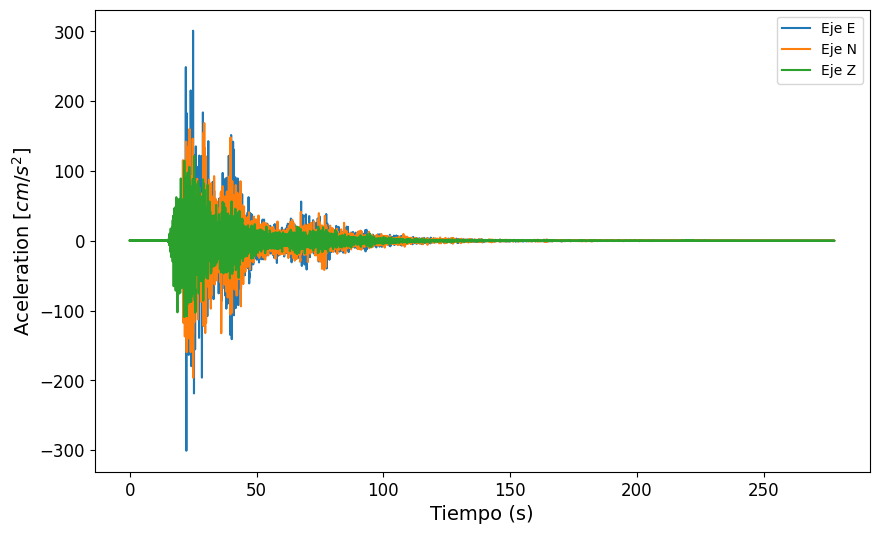

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_igp['tiempo_s'], df_igp['E'], label='Eje E')
plt.plot(df_igp['tiempo_s'], df_igp['N'], label='Eje N')
plt.plot(df_igp['tiempo_s'], df_igp['Z'], label='Eje Z')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Aceleration $[cm/s^2]$', fontsize=14)
plt.legend()

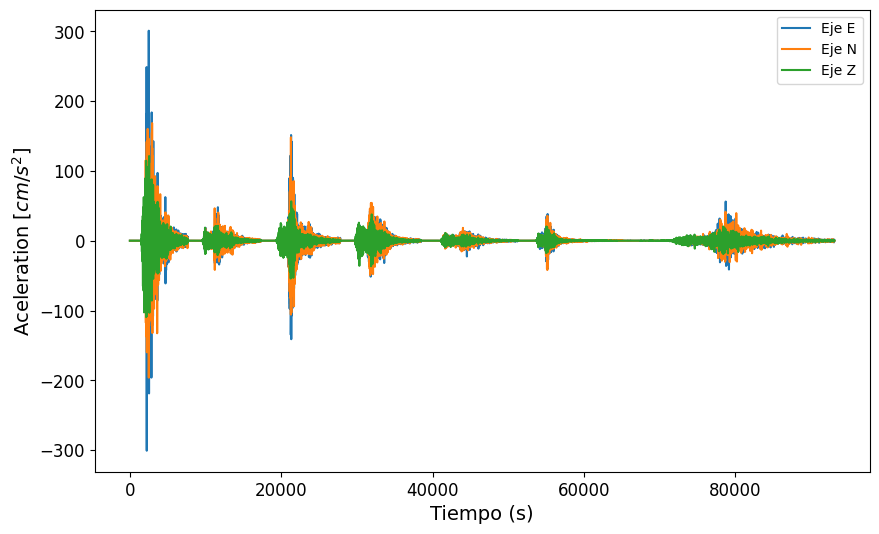

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_igp['E'], label='Eje E')
plt.plot(df_igp['N'], label='Eje N')
plt.plot(df_igp['Z'], label='Eje Z')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Aceleration $[cm/s^2]$', fontsize=14)
plt.legend()

In [ ]:
estacion = "Yauca, Caravelí, Arequipa"
df_yauca = df_igp[df_igp["nombre_estacion"] == estacion]


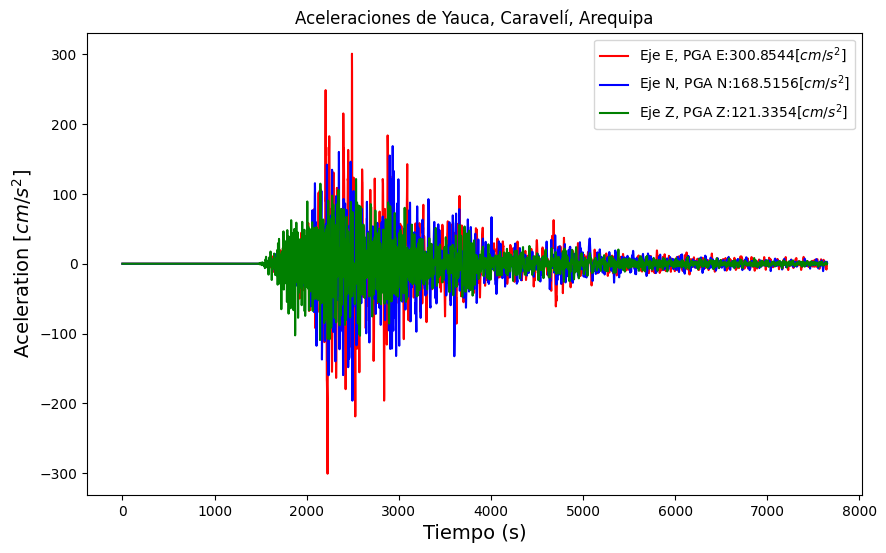

In [ ]:
plt.figure(figsize=(10, 6))
#calculo del PGA
PGA_E=df_yauca['E'].max()
PGA_N=df_yauca['N'].max()
PGA_Z=df_yauca['Z'].max()
plt.plot(df_yauca['E'],color="r", label='Eje E, PGA E:'+str(np.round(PGA_E,4))+'$[cm/s^2]$')
plt.plot(df_yauca['N'],color="b", label='Eje N, PGA N:'+str(np.round(PGA_N,4))+'$[cm/s^2]$')
plt.plot(df_yauca['Z'],color="g", label='Eje Z, PGA Z:'+str(np.round(PGA_Z,4))+'$[cm/s^2]$')

plt.tick_params(axis='both', which='major', labelsize=10)
plt.title(f"Aceleraciones de {estacion}")
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Aceleration $[cm/s^2]$', fontsize=14)
plt.legend()